In [1]:
!pip install git+https://github.com/messari/messari-python-api.git
!pip install yfinance prophet

  Cloning https://github.com/messari/messari-python-api.git to /private/var/folders/ks/0nlmbx4j0rg3pzjsgw_7b7rw0000gn/T/pip-req-build-bt5ecy7l
  Running command git clone -q https://github.com/messari/messari-python-api.git /private/var/folders/ks/0nlmbx4j0rg3pzjsgw_7b7rw0000gn/T/pip-req-build-bt5ecy7l
  Resolved https://github.com/messari/messari-python-api.git to commit 79a204e6a12111402833287e4fdbdb088d22fa4a


In [2]:
from messari.messari import Messari

messari = Messari()
assets = ['bitcoin']
metric = 'price'
start = '2020-01-01'
end = '2023-01-01'
df = messari.get_metric_timeseries(asset_slugs=assets, asset_metric=metric, start=start, end=end)
df = df[f'{assets[0]}']

In [3]:
dates = df.reset_index()['timestamp'].tolist()
close = df['close'].tolist()

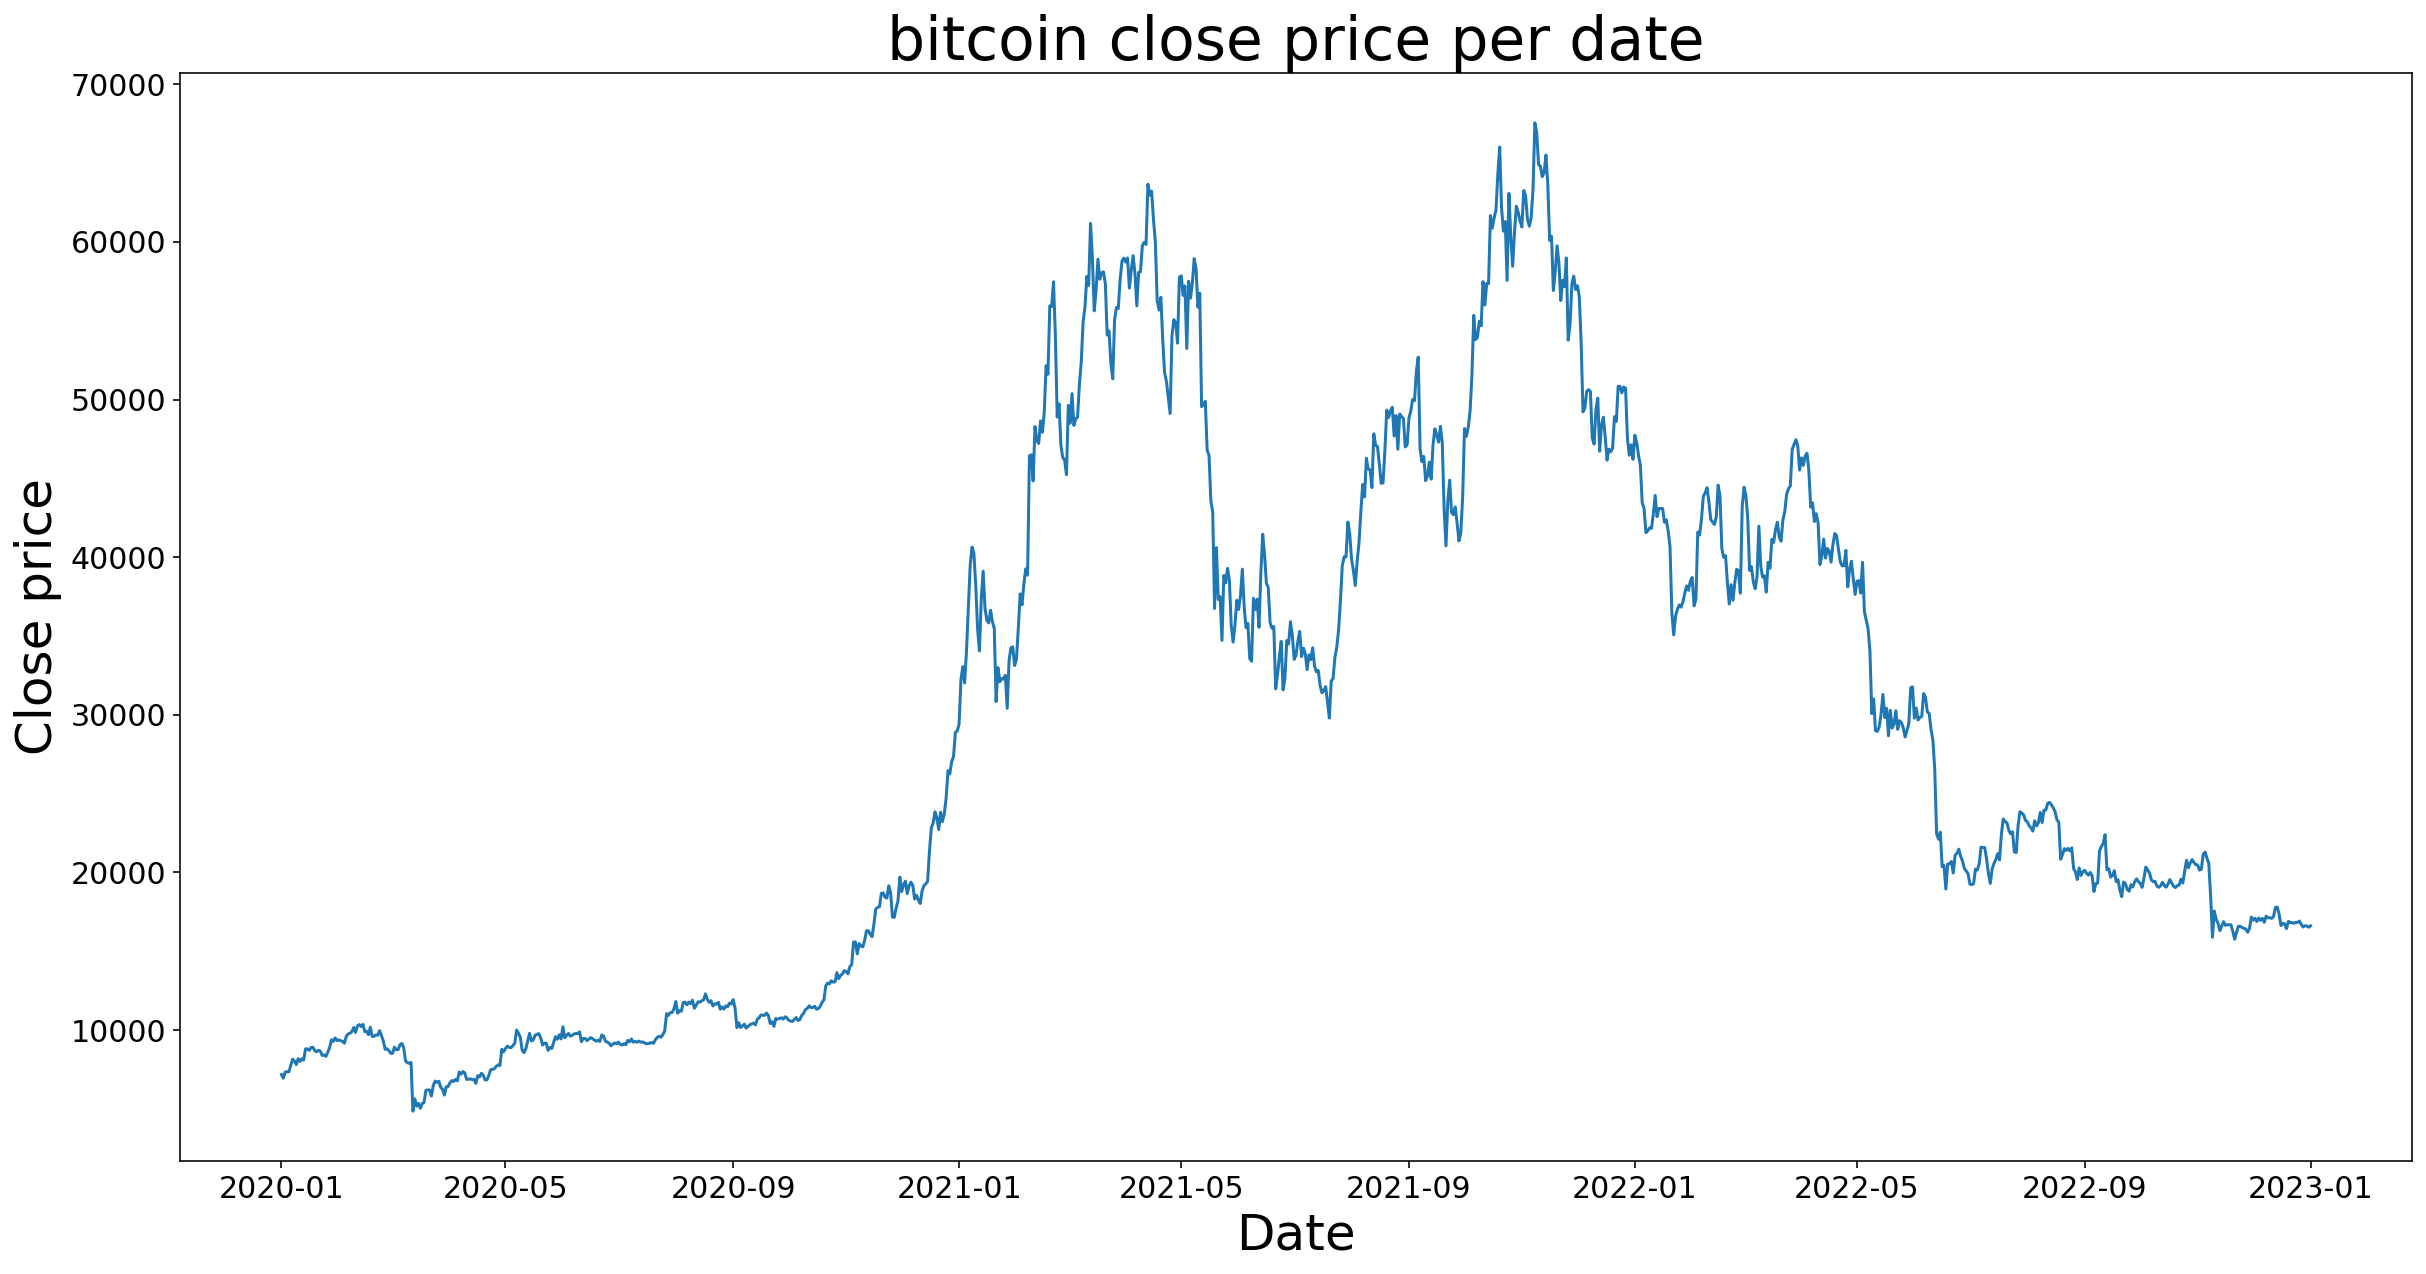

In [4]:
import matplotlib.pyplot as plt
import numpy as np
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = 20, 10
plt.plot(dates, close)
plt.xlabel("Date", fontsize = 25)
plt.ylabel("Close price", fontsize = 25)
plt.title(f"{assets[0]} close price per date", fontsize = 30)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.show()

In [5]:
from sklearn.model_selection import train_test_split
period = 7
test_y = close[-period:]
test_dates = dates[-period:]
val_y = close[-2*period:-period]
val_dates = dates[-2*period:-period]
df = df.reset_index().drop(['open', 'high', 'low', 'volume'], axis=1)
df.rename(columns={'timestamp': 'ds', 'close': 'y'}, inplace=True)
train, test = train_test_split(df, test_size=period, shuffle=False)
train, val = train_test_split(train, test_size=period, shuffle=False)

### Let's tune the parameters. ###

In [6]:
from prophet import Prophet
from sklearn.metrics import mean_squared_error
import logging

logger = logging.getLogger('cmdstanpy')
logger.addHandler(logging.NullHandler())
logger.propagate = False
logger.setLevel(logging.CRITICAL)

changepoint_prior_scale_values = np.linspace(0.01, 0.1, num=10)
changepoint_range_values = np.linspace(0.8, 0.95, num=4)
best_RMSE = np.inf
best_CPS = 0
best_CR = 0

for changepoint_prior_scale_ in changepoint_prior_scale_values:
    for changepoint_range_ in changepoint_range_values:
        model = Prophet(changepoint_prior_scale=changepoint_prior_scale_, changepoint_range=changepoint_range_)
        model.fit(train)
        future = model.make_future_dataframe(periods=period)
        forecast = model.predict(future)
        val_pred = np.array(forecast['yhat'][-period:])
        val_RMSE = mean_squared_error(val_y, val_pred, squared=False)
        if val_RMSE < best_RMSE:
            best_RMSE = val_RMSE
            best_CPS = changepoint_prior_scale_
            best_CR = changepoint_range_
              
print("Best RMSE = %.3f" % best_RMSE, sep="")
print("Best changepoint prior scale = ", best_CPS, sep="")
print("Best changepoint range = ", best_CR, sep="")

Best RMSE = 1734.966
Best changepoint prior scale = 0.09000000000000001
Best changepoint range = 0.95


### Best model predictions. ###

In [7]:
best_model = Prophet(changepoint_prior_scale=best_CPS, changepoint_range=best_CR)
best_model.fit(train)
future = best_model.make_future_dataframe(periods=period)
forecast = best_model.predict(future)
val_pred = np.array(forecast['yhat'][-period:])
val_RMSE = mean_squared_error(val_y, val_pred, squared=False)
val_rel_error = ((abs(val_y - val_pred)) / val_y) * 100
print("Validation RMSE = %.3f" % val_RMSE, sep="")
print("Validation relative error = %.3f" % val_rel_error.mean(), '%', sep="")
print("Last validation relative error = %.3f" % val_rel_error[-1], '%', sep="")

Validation RMSE = 1734.966
Validation relative error = 10.194%
Last validation relative error = 7.306%


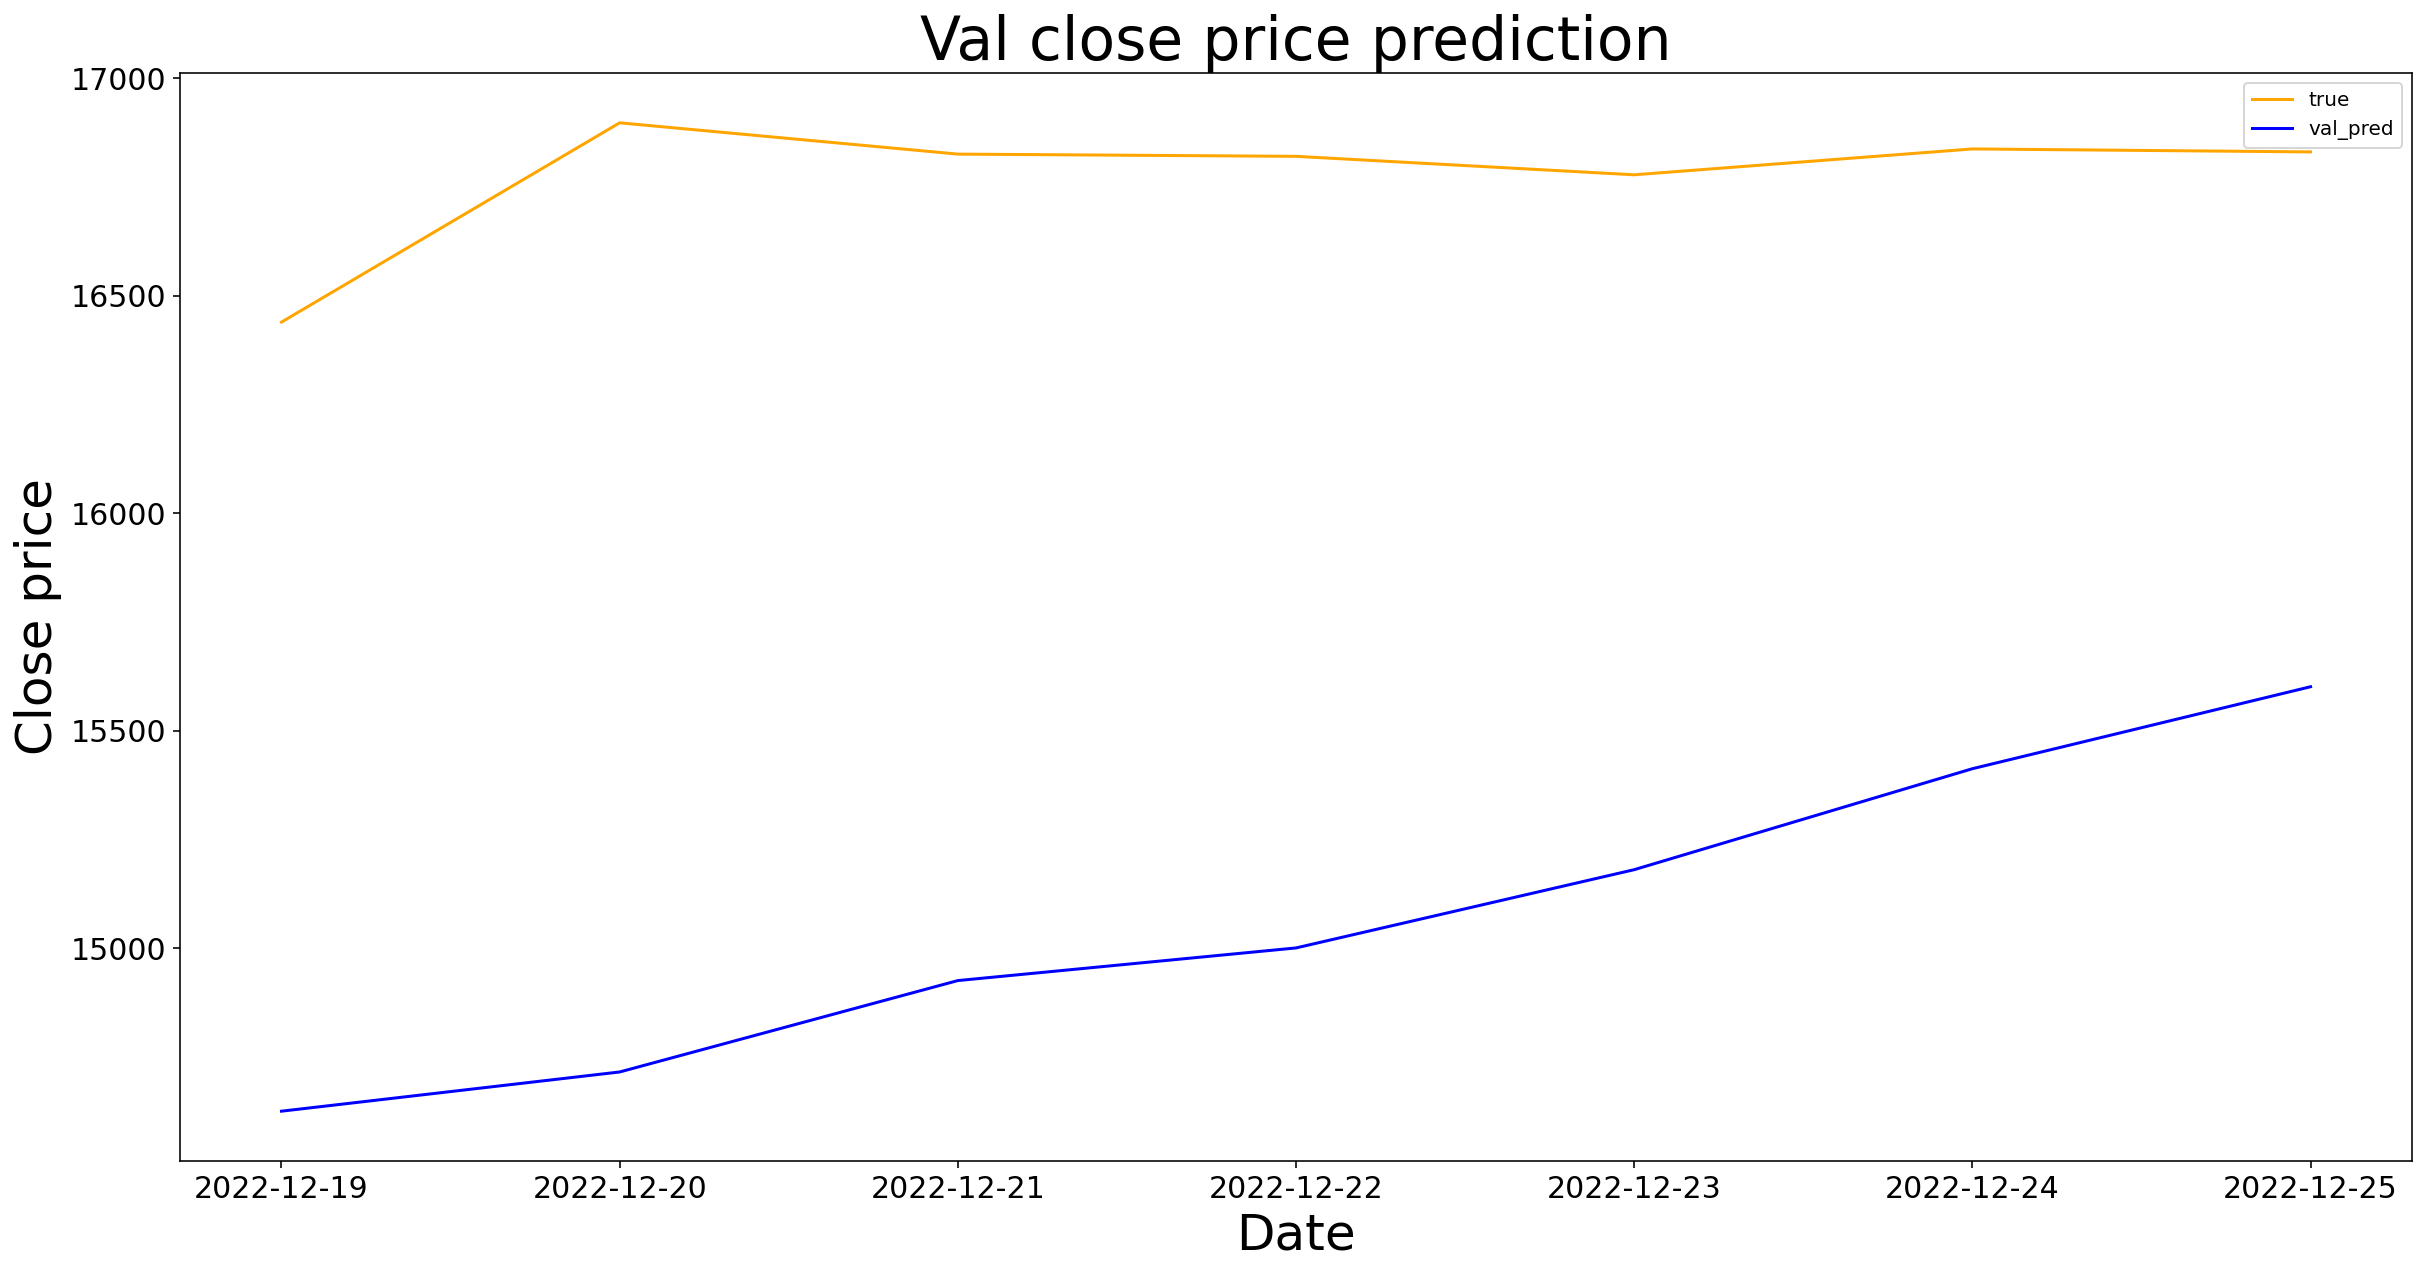

In [8]:
plt.title("Val close price prediction", fontsize = 30)
plt.plot(val_dates, val_y, color = 'orange', label = 'true')
plt.plot(val_dates, val_pred, color = 'blue', label = 'val_pred')
plt.xlabel("Date", fontsize = 25)
plt.ylabel("Close price", fontsize = 25)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend()
plt.show()

In [9]:
best_model = Prophet(changepoint_prior_scale=best_CPS, changepoint_range=best_CR)
best_model.fit(train.append(val))
future = best_model.make_future_dataframe(periods=period)
forecast = best_model.predict(future)
test_pred = np.array(forecast['yhat'][-period:])
test_RMSE = mean_squared_error(test_y, test_pred, squared=False)
test_rel_error = ((abs(test_y - test_pred)) / val_y) * 100
print("Test RMSE = %.3f" % test_RMSE, sep="")
print("Test relative error = %.3f" % test_rel_error.mean(), '%', sep="")
print("Last test relative error = %.3f" % test_rel_error[-1], '%', sep="")

Test RMSE = 975.625
Test relative error = 5.114%
Last test relative error = 8.419%


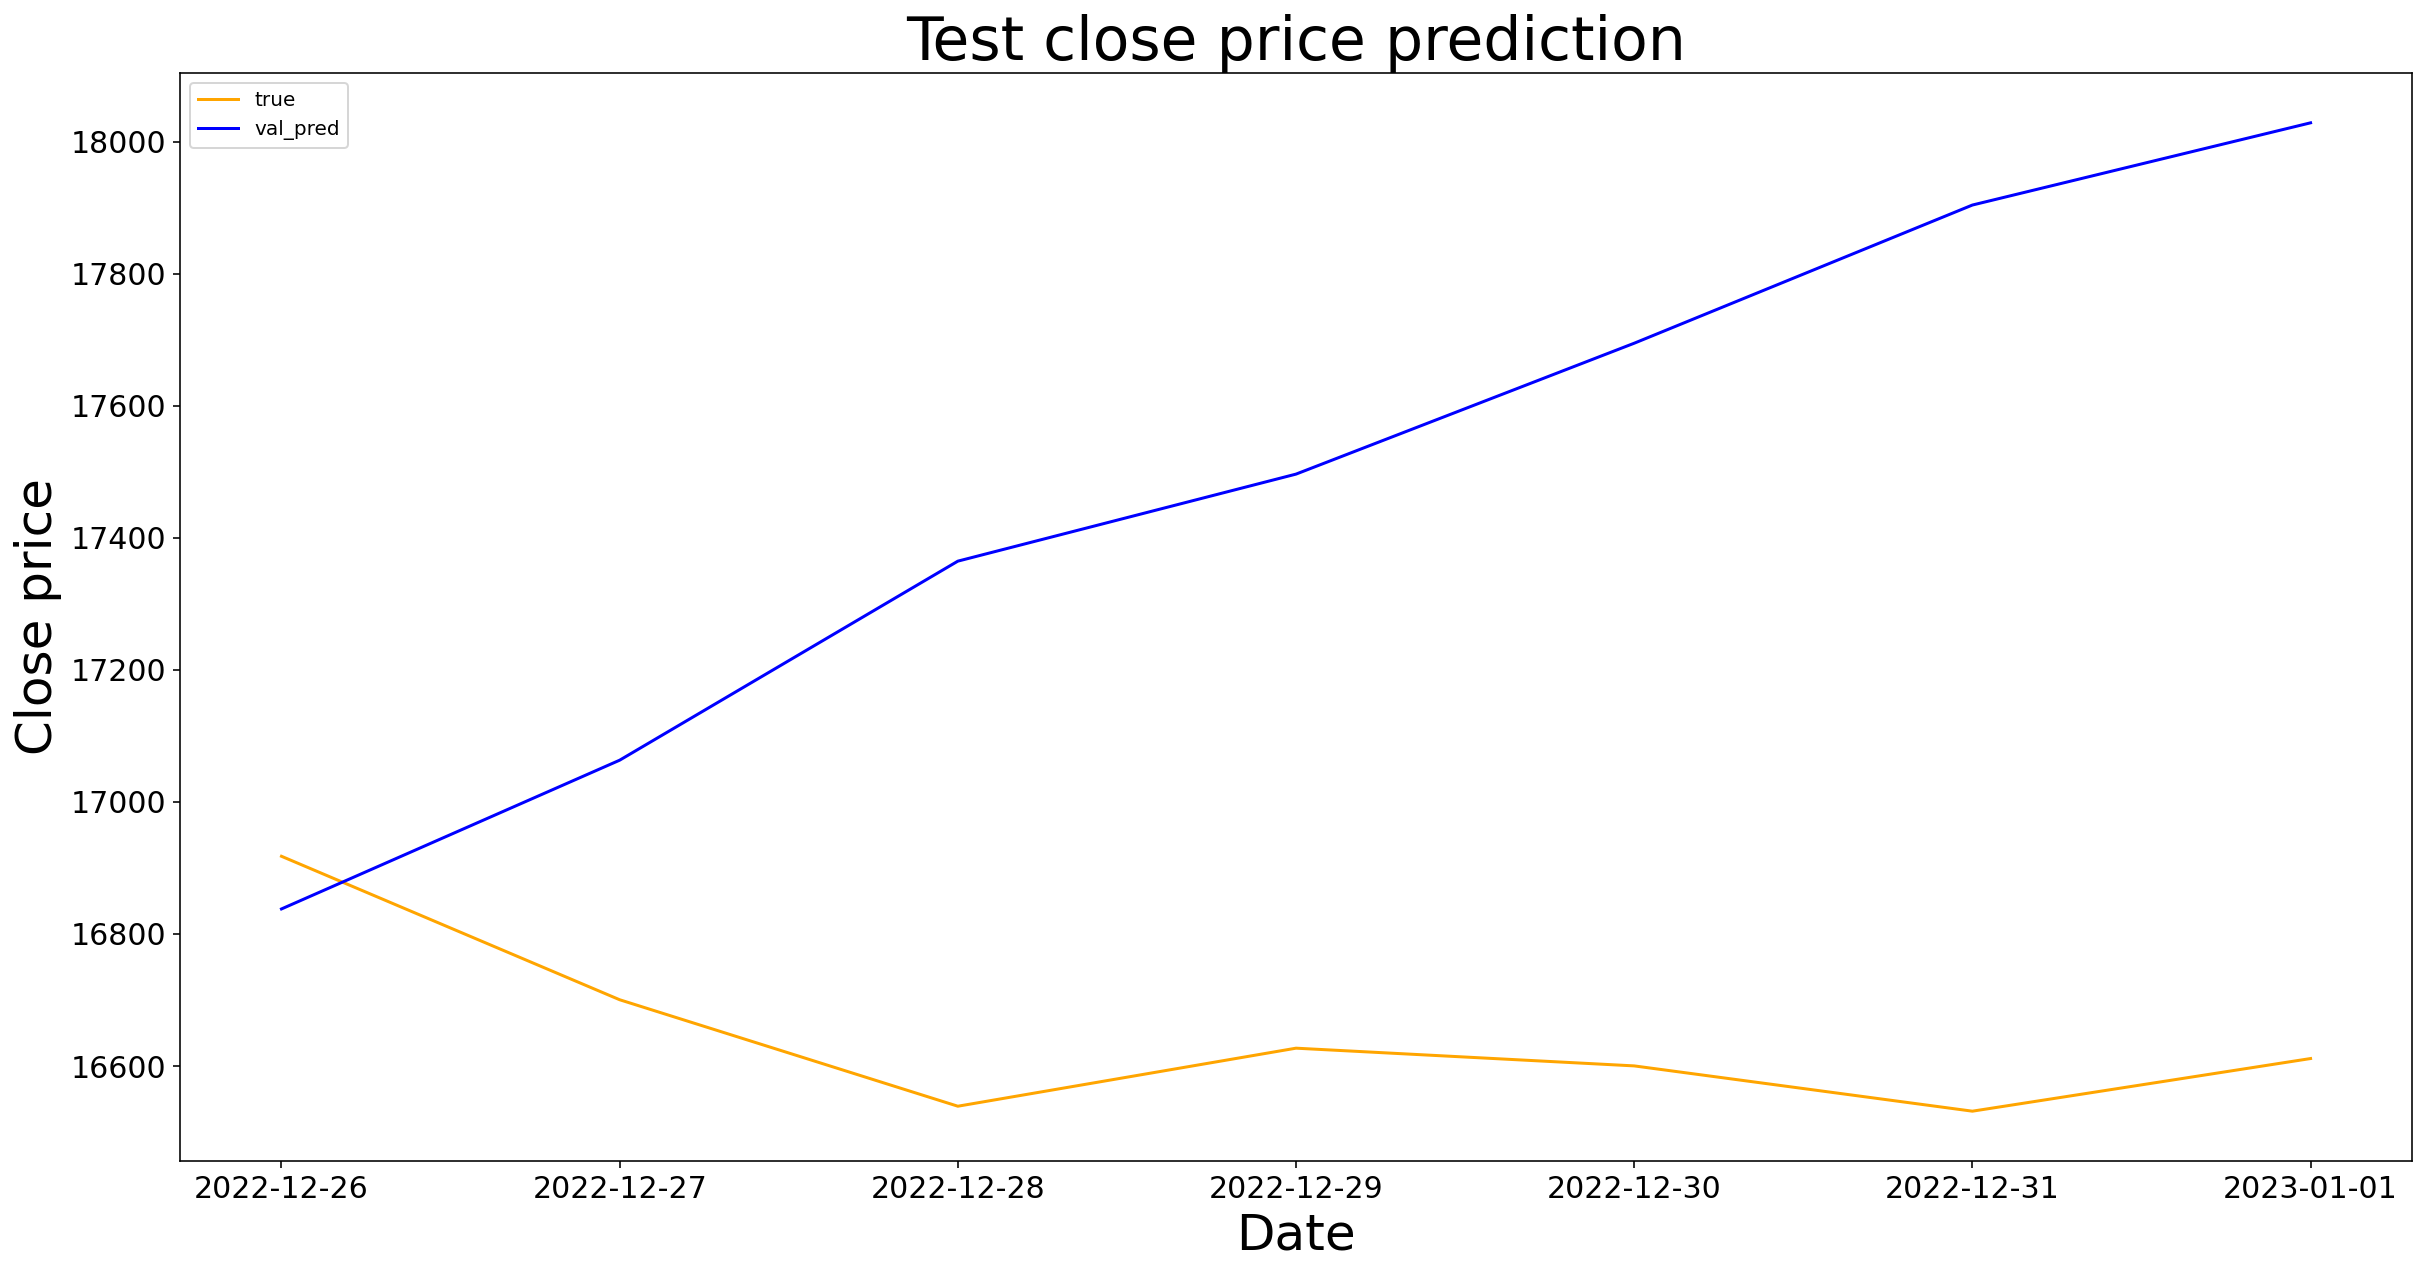

In [10]:
plt.title("Test close price prediction", fontsize = 30)
plt.plot(test_dates, test_y, color = 'orange', label = 'true')
plt.plot(test_dates, test_pred, color = 'blue', label = 'val_pred')
plt.xlabel("Date", fontsize = 25)
plt.ylabel("Close price", fontsize = 25)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend()
plt.show()

### Future predictions. ###

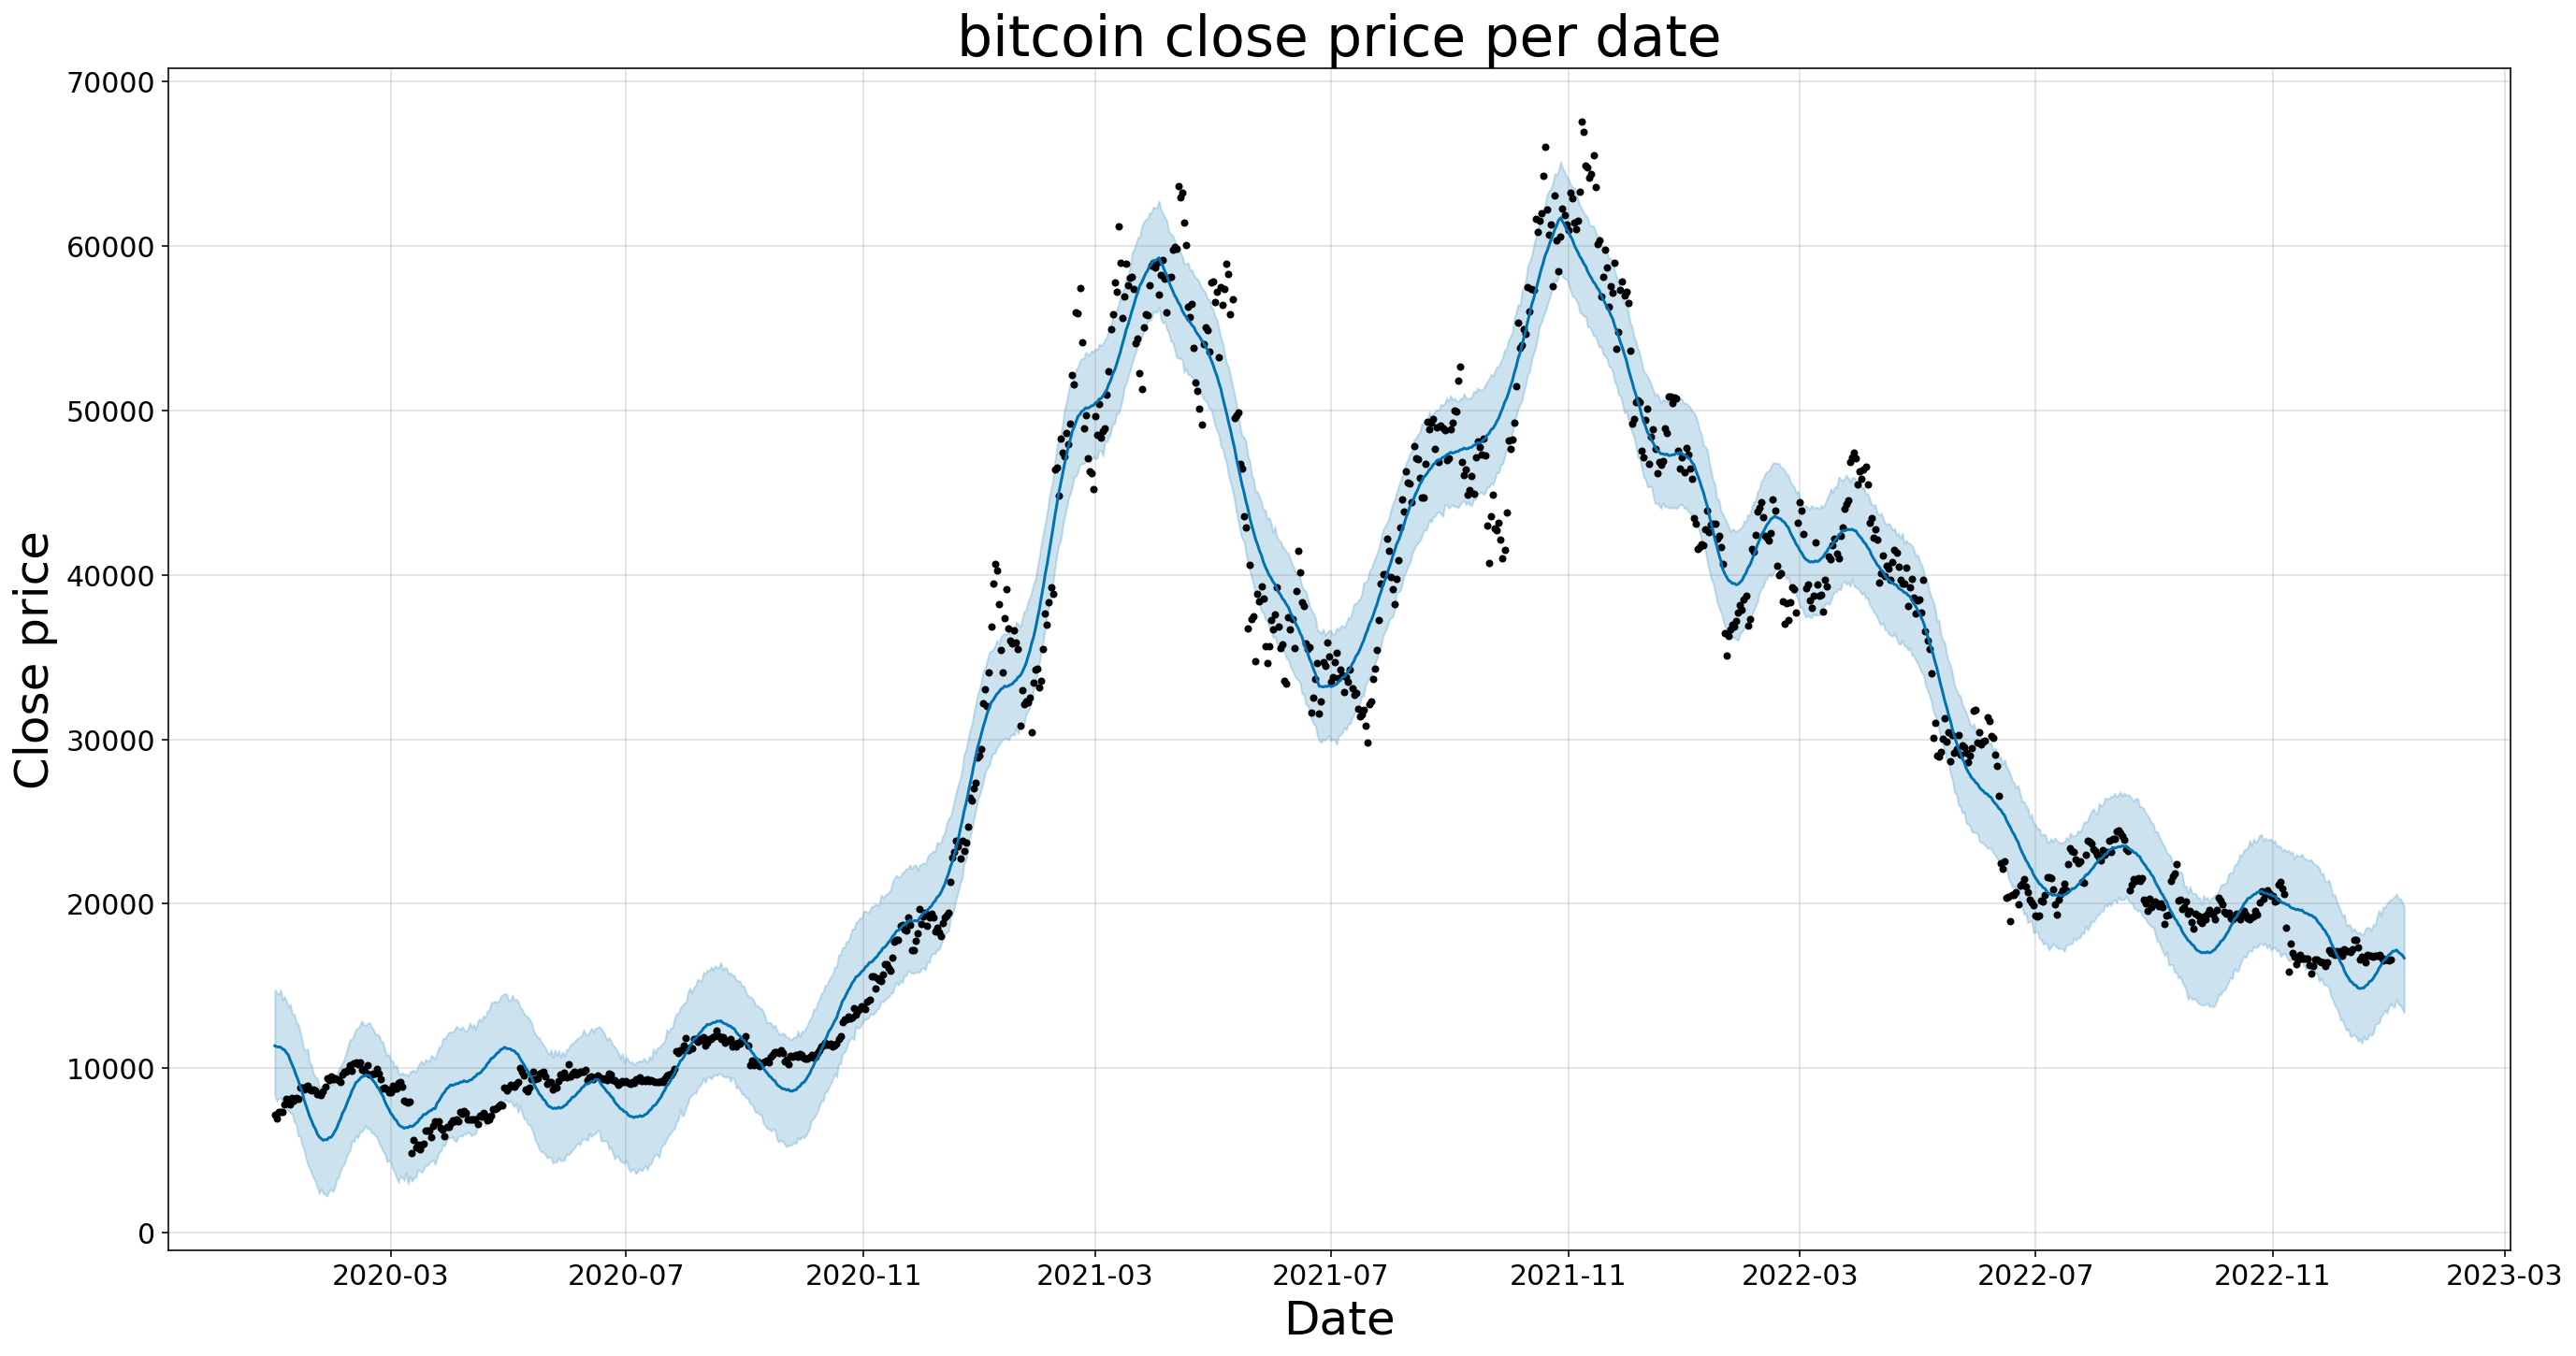

Predicted price of bitcoin through 7 days = 16690.211
bitcoin change in percents = 0.474%


In [11]:
best_model = Prophet(changepoint_prior_scale=best_CPS, changepoint_range=best_CR)
best_model.fit(df)
future = best_model.make_future_dataframe(periods=period)
forecast = best_model.predict(future)
future_pred = np.array(forecast['yhat'][-period:])

fig = best_model.plot(forecast, xlabel='Date', ylabel='Close price')
fig.set_figwidth(20)
fig.set_figheight(10)
plt.xlabel("Date", fontsize = 25)
plt.ylabel("Close price", fontsize = 25)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title(f"{assets[0]} close price per date", fontsize = 30)
plt.show()

last_pred = future_pred[-1]
change_pred = (last_pred - close[-1]) / close[-1] * 100
print(f"Predicted price of {assets[0]} through {period} days = %.3f" % last_pred, sep="")
print(f"{assets[0]} change in percents = %.3f" % change_pred, '%', sep="")

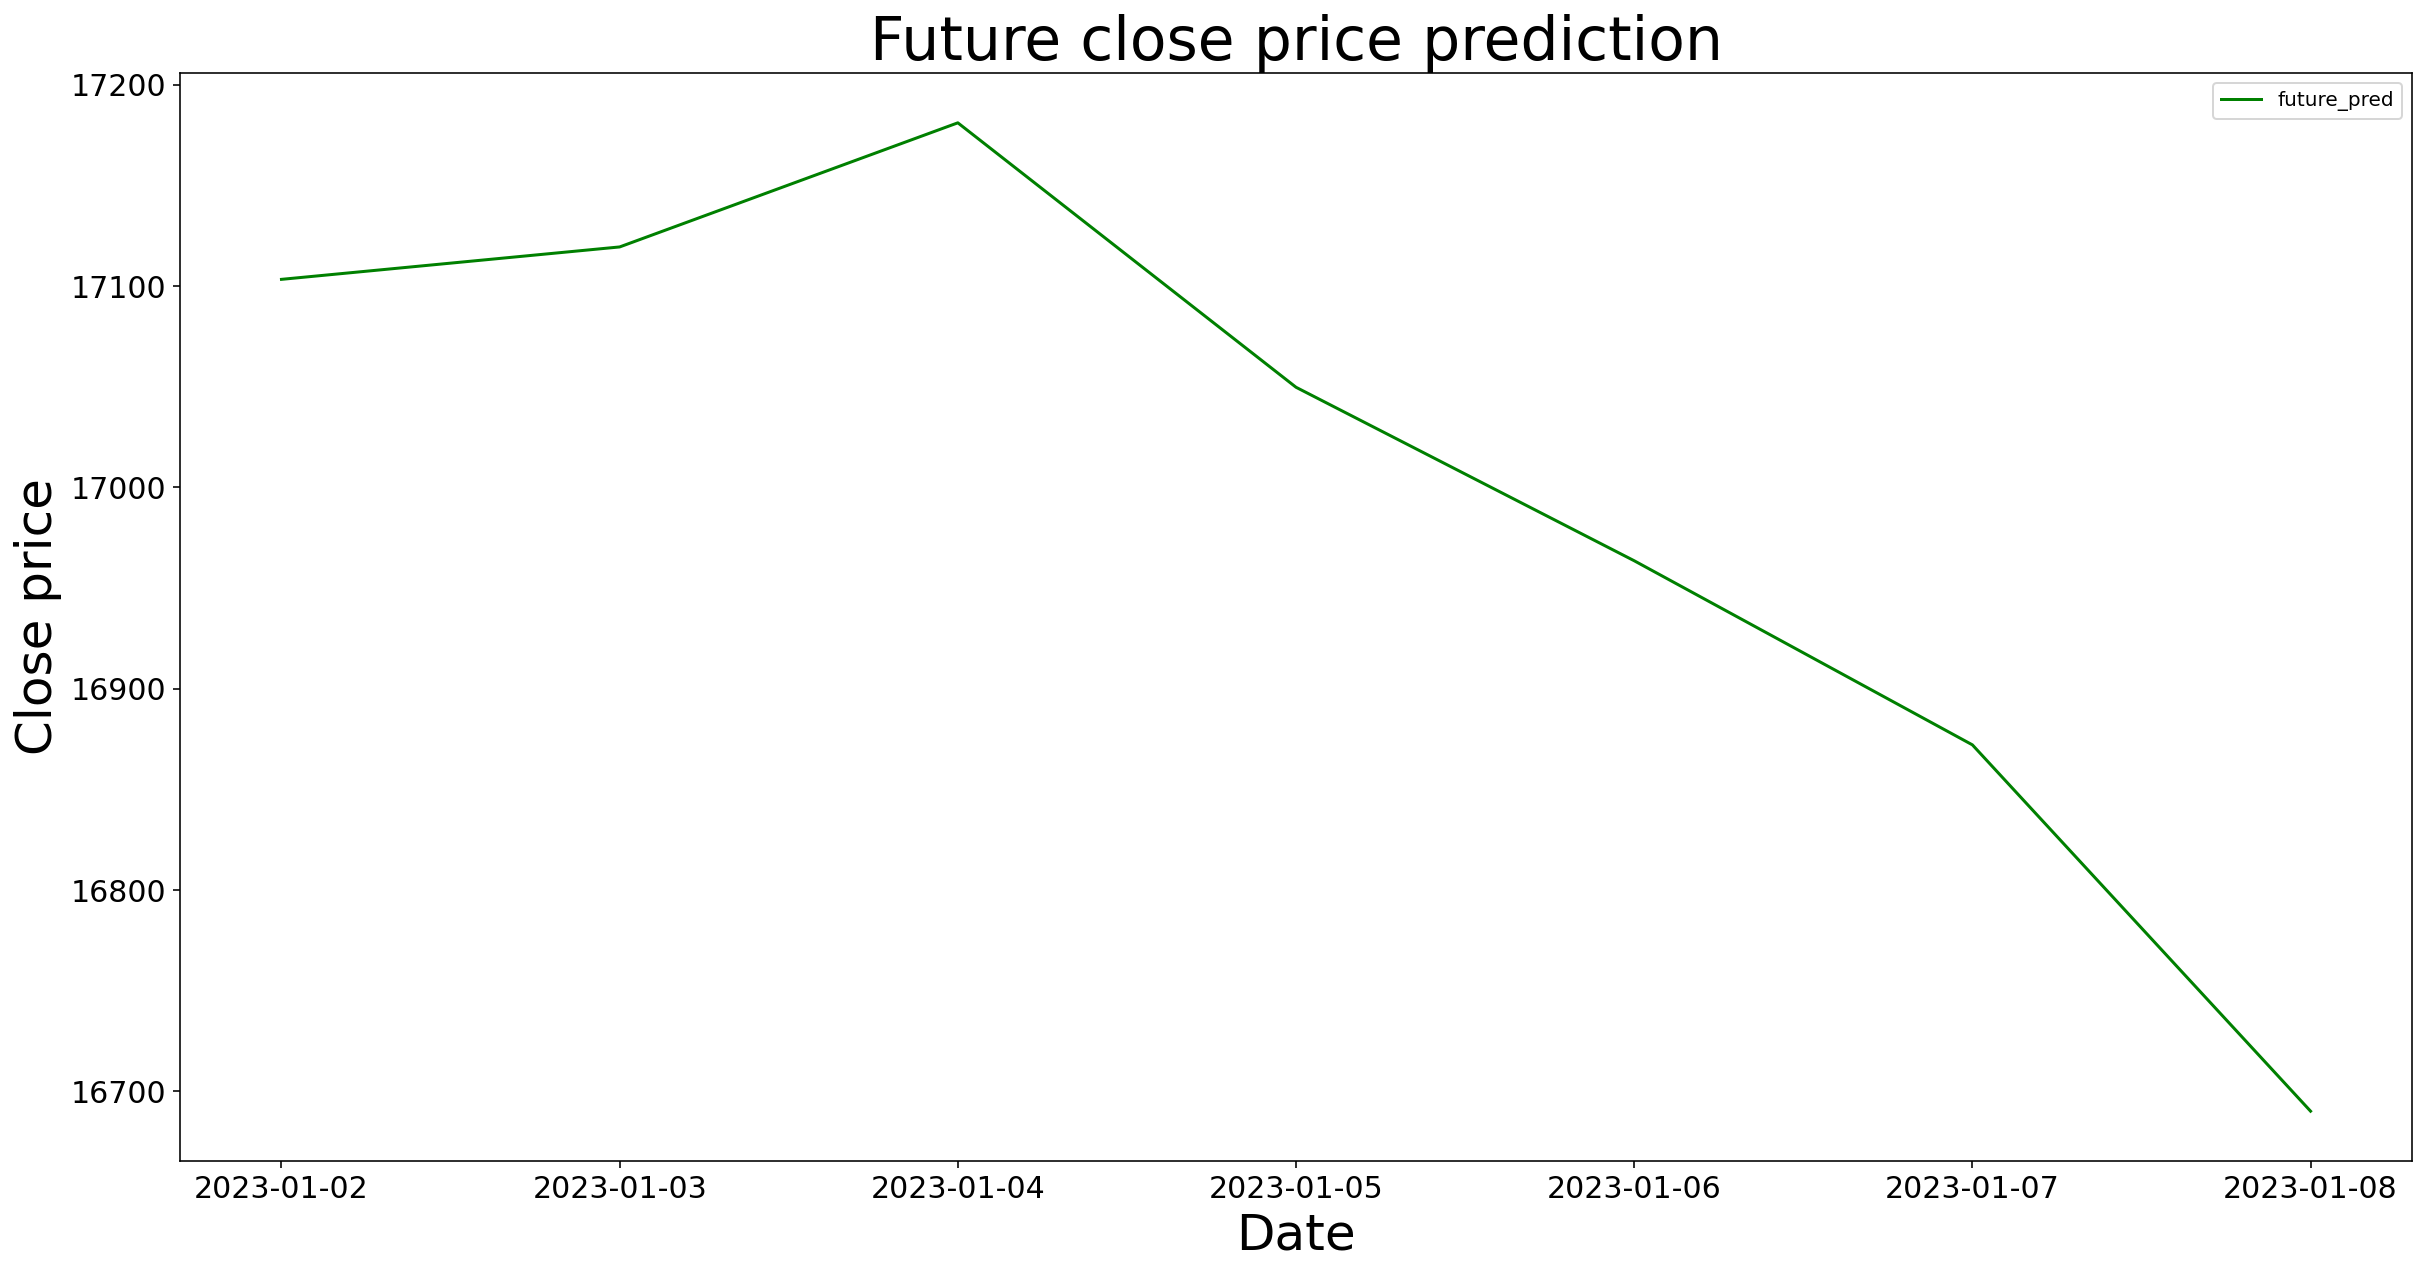

In [12]:
import pandas as pd
future_dates = pd.date_range(start='2023-01-02', end='2023-01-08')
plt.title("Future close price prediction", fontsize = 30)
plt.plot(future_dates, future_pred, color = 'green', label = 'future_pred')
plt.xlabel("Date", fontsize = 25)
plt.ylabel("Close price", fontsize = 25)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend()
plt.show()